## Projeto Real Estate   

Este projeto foi desenvolvido em caráter fictício com o objetivo de colocar em prática os conhecimentos adquiridos durante a terceira semana do treinamento Aceleradev Data Science fornecido pela [Codenation](https://codenation.dev/).

<img src="capa.png" width="1000" height="1000"/>

### Entendimento do Negócio  
Fomos contratados pela empresa **Real Estate**, especializada na administração de imóveis. O CEO da Real Estate deseja automatizar a etapa de disponibilização do imóvel para locação.  

Nosso objetivo é fornecer uma plataforma capaz de estimar o valor do aluguel para o imóvel de acordo com as características fornecidas pelo proprietário, permitindo que todo o processo de anúncio do imóvel seja realizada pelo usuário.  

### Entendimento e Limpeza dos Dados
Nesta etapa iremos preparar os dados para a análise exploratória.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

C:\Users\Bruno\anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df_houses = pd.read_csv('houses_to_rent_v2.csv')
df_houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


Temos **10692 observações** e **13 atributos** em nosso conjunto de dados.

In [3]:
df_houses.shape

(10692, 13)

**Atributos**:
* **city**: cidade onde o imóvel está localizado.  
* **area**: área do imóvel (m²).
* **rooms**: quantidade de quartos.  
* **bathroom**: quantidade de banheiros.  
* **parking spaces**: quantidade de vagas no estacionamento.  
* **floor**: nº do andar.  
* **animal**: indica se o imóvel permite ou não a presença de animais.  
* **furniture**: indica se o imóvel possuí mobília. 
* **hoa**: valor do condomínio.  
* **rent amount**: valor do aluguel.  
* **property tax**: IPTU.  
* **fire insurance**: seguro contra incêndio.  
* **total**: (rent amount + hoa + property tax + fire insurance).  

In [4]:
df_houses.dtypes

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

Não temos a ocorrência de valores nulos em nosso conjunto, portanto **não será necessário realizar a imputação de dados.**

In [5]:
df_houses.isna().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

Iremos renomear algumas colunas com o objetivo de facilitar seu acesso posteriormente.

In [6]:
df_houses.rename(columns={'hoa (R$)':'hoa','rent amount (R$)':'rent_amount','property tax (R$)':'property_tax',
                    'fire insurance (R$)':'fire_insurance','total (R$)':'total'}, inplace=True)

In [7]:
df_houses.describe()

,area,rooms,bathroom,parking spaces,hoa,rent_amount,property_tax,fire_insurance,total
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


Investigaremos alguns atributos considerando a discrepância verificada entre o percentil 75 e o valor máximo, além do desvio padrão em relação a média.  

Para remover os **outliers**, iremos utilizar a regra da amplitude interquartil, descartando os valores que ultrapassam o limite inferior e superior:
<img src="iqr.png" width="500" height="500"/>

In [8]:
def lowerUpperLimit(data):
    Q1 = data.quantile(.25)
    Q3 = data.quantile(.75)
    IQR = Q3 - Q1
    minimum = Q1 - 1.5 * IQR
    maximum = Q3 + 1.5 * IQR
    
    return minimum, maximum

* **Area**

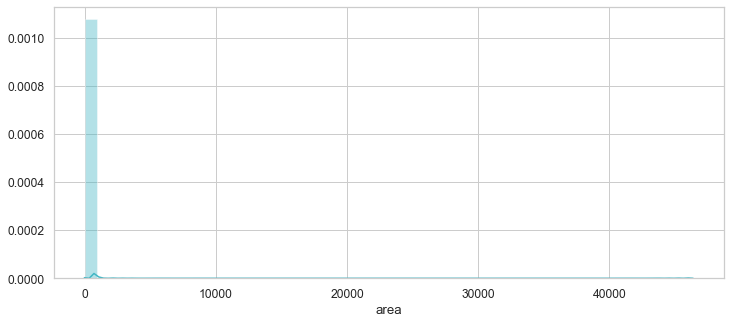

In [9]:
sns.set(style='whitegrid', font_scale=1.1, rc={"figure.figsize": [12, 5]})
sns.distplot(df_houses['area'], color='#41b6c4');

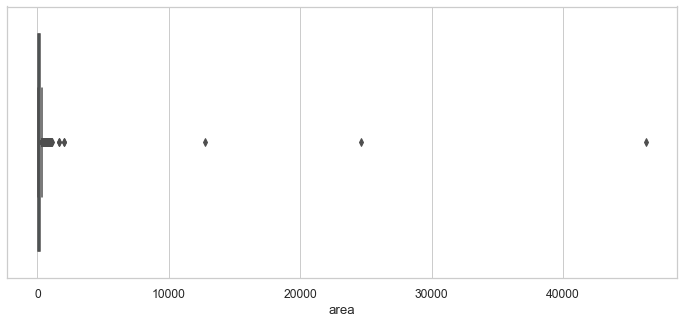

In [10]:
sns.boxplot('area', data=df_houses, color='#41b6c4');

In [11]:
lower_limit_area, upper_limit_area = lowerUpperLimit(df_houses['area'])
df_cleaned = df_houses.drop(df_houses.query('area < @lower_limit_area | area > @upper_limit_area').index)

Vamos verificar a distribuição do atributo *area* após a remoção dos outliers:

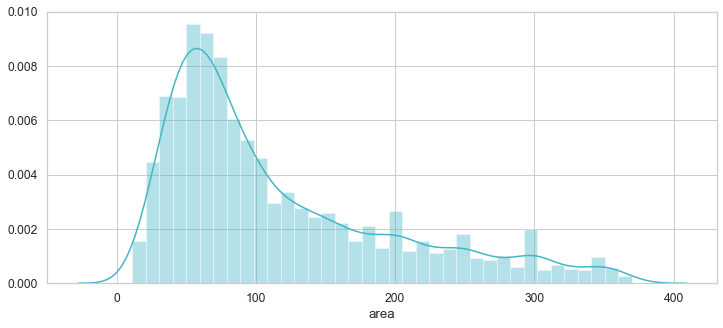

In [12]:
sns.distplot(df_cleaned['area'], color='#41b6c4');

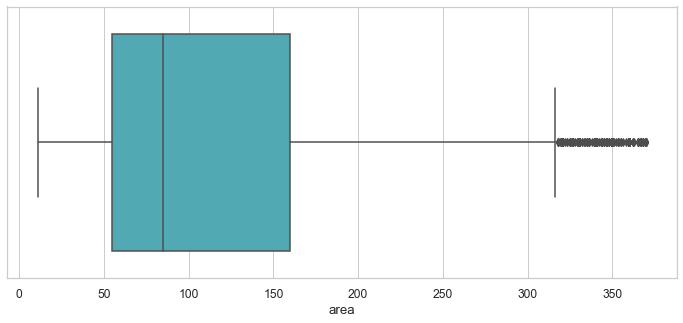

In [13]:
sns.boxplot('area', data=df_cleaned, color='#41b6c4');

In [14]:
df_cleaned['area'].mean()

116.06477045908184

Sem a presença de outliers somos capazer de analisar a distribuição do atributo _area_ e verificar que **a maioria dos imóveis possuem área entre 55 m² e 160 m², com o tamanho médio de 116 m²**.

* **Rent Amount**

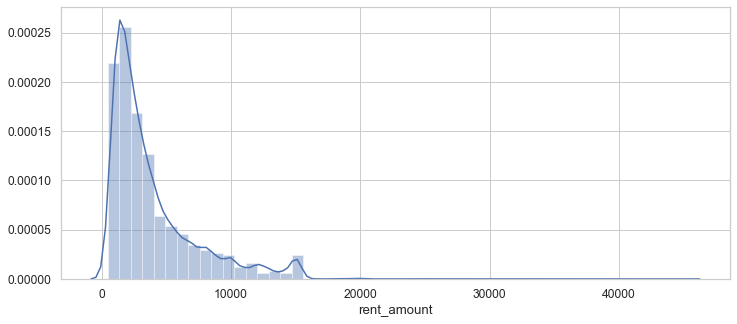

In [15]:
sns.distplot(df_houses['rent_amount']);

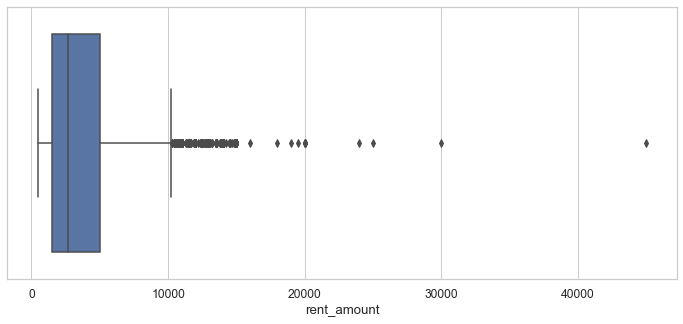

In [16]:
sns.boxplot('rent_amount', data=df_houses);

In [17]:
lower_limit_rent, upper_limit_rent = lowerUpperLimit(df_houses['rent_amount'])
df_cleaned.drop(df_cleaned.query('rent_amount < @lower_limit_rent | rent_amount > @upper_limit_rent').index, inplace=True)

Agora vamos verificar como ficou a distribuição do atributo *rent_amount* após a remoção dos outliers:

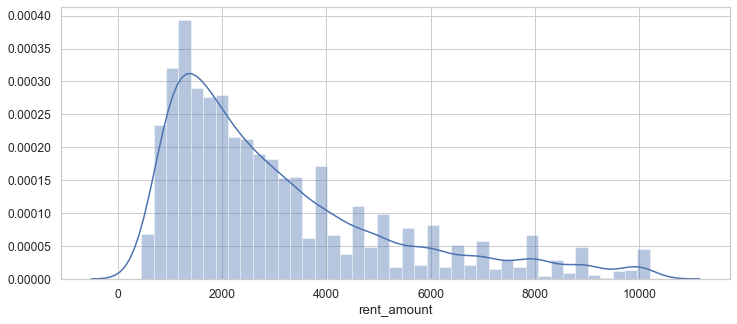

In [18]:
sns.distplot(df_cleaned['rent_amount']);

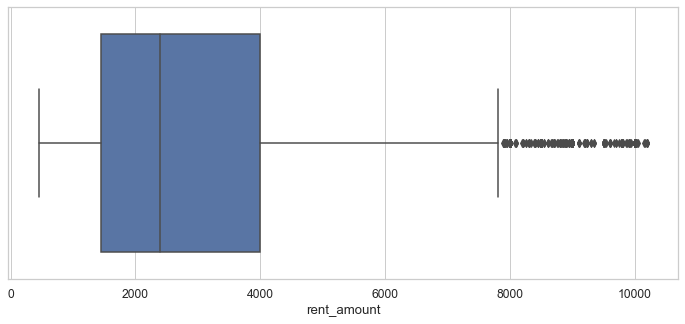

In [19]:
sns.boxplot('rent_amount', data=df_cleaned);

In [20]:
df_cleaned['rent_amount'].mean()

3064.944305120167

Após a remoção dos outliers, podemos observar que **a maioria dos imóveis custam entre R\\$ 1500 e R\\$ 4000 para locação, com o valor médio de R\$ 3064**.

* **Floor**

In [21]:
df_cleaned['floor'].unique()

array(['7', '20', '6', '2', '1', '4', '10', '11', '24', '-', '9', '8',
       '17', '18', '5', '3', '13', '15', '16', '14', '26', '21', '12',
       '19', '22', '27', '23', '25', '46', '28', '29', '301', '51', '32'],
      dtype=object)

Apesar de ser um valor inteiro, o atributo _floor_ está representado como string. 

In [22]:
df_cleaned['floor'].replace(to_replace='-', value=0, inplace=True)
df_cleaned['floor'] = df_cleaned['floor'].astype(int)

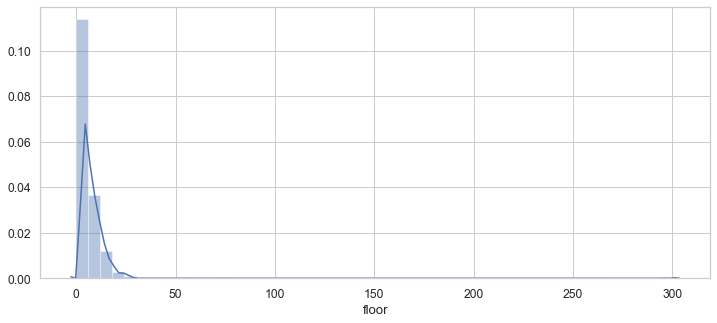

In [23]:
sns.distplot(df_cleaned['floor']);

In [24]:
df_cleaned['floor'].describe()

count    9570.000000
mean        5.127482
std         6.029420
min         0.000000
25%         1.000000
50%         4.000000
75%         8.000000
max       301.000000
Name: floor, dtype: float64

In [25]:
lower_limit_floor, upper_limit_floor = lowerUpperLimit(df_cleaned['floor'])
lower_limit_floor, upper_limit_floor

(-9.5, 18.5)

Antes de remover os valores que ultrapassam o limite, é importante verificar se faz sentido para o problema. Neste caso, é comum em grandes centros prédios residenciais que ultrapassam o limite de 18.5 andares. Arranha-Céus são prédios que ultrapassam 40 andares, vamos verificar se temos arranha-céus em nosso conjunto de dados:

In [26]:
df_cleaned[df_cleaned['floor'] > 40]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
1654,São Paulo,353,4,5,5,46,acept,not furnished,3000,10000,0,127,13130
2562,Belo Horizonte,80,3,2,2,301,acept,not furnished,750,2600,164,35,3549
5694,Campinas,64,2,2,2,51,acept,not furnished,800,1900,129,25,2854


Considerações:
* Atualmente, o [prédio mais alto de São Paulo](https://www.imovelweb.com.br/noticias/arquitetura/os-5-predios-mais-altos-brasil/) é o Mirante do Vale, com 51 andares;
* O [prédio mais alto de campinas](https://www.acidadeon.com/campinas/cotidiano/cidades/NOT,0,0,1347473,predio+mais+alto+de+campinas+edificio+mirante+tem+44+anos.aspx) tem 30 andares;
* O [prédio mais alto do mundo](https://casavogue.globo.com/Arquitetura/Edificios/noticia/2019/10/conheca-os-10-predios-mais-altos-do-mundo.html#:~:text=Burj%20Khalifa%20(Emirados%20%C3%81rabes)&text=%C3%89%20do%20Burj%20Khalifa%2C%20em,828%20metros%20e%20160%20andares.) possuí 160 andares, portanto, a ocorrência do prédio em Belo Horizonte com 301 andares se trata de um erro de inserção nos dados.

De acordo com as considerações feitas anteriormente, iremos manter apenas o imóvel localizado em São Paulo.

In [27]:
df_cleaned.drop(df_cleaned.loc[(df_cleaned['floor'] > 46)].index, inplace=True)

Vamos verificar a distribuição dos nossos dados após a remoção dos **outliers**:

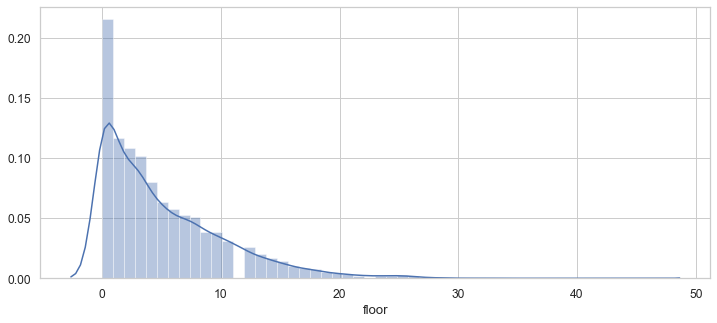

In [28]:
sns.distplot(df_cleaned['floor']);

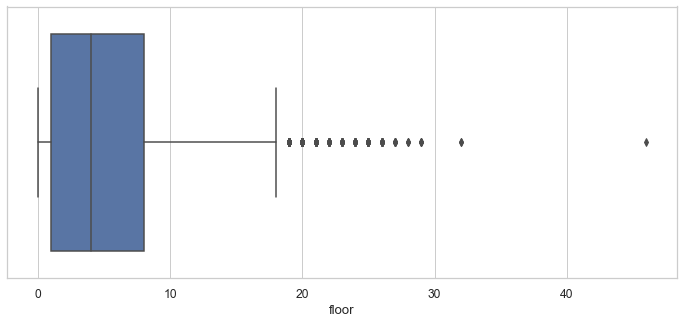

In [29]:
sns.boxplot(df_cleaned['floor']);

Analisando a distribuição do atributo *floor*, é possível verificar que a **maioria dos imóveis estão localizados no térreo** e que **75% dos imóveis estão localizados a menos de 10 andares.**

* **Hoa (Taxa de condomínio)**

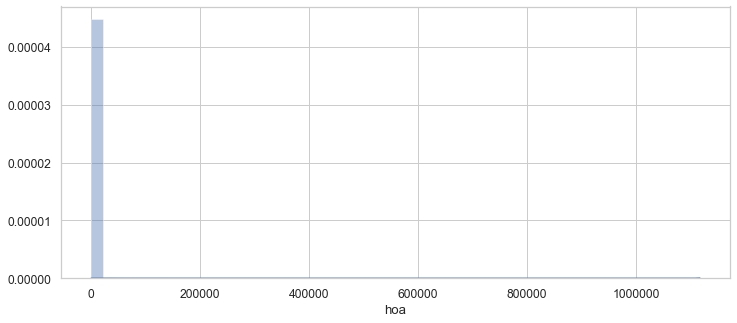

In [30]:
sns.distplot(df_cleaned['hoa']);

In [31]:
lower_limit_hoa, upper_limit_hoa = lowerUpperLimit(df_cleaned['hoa'])
df_cleaned.drop(df_cleaned.query('hoa < @lower_limit_hoa | hoa > @upper_limit_hoa').index, inplace=True)

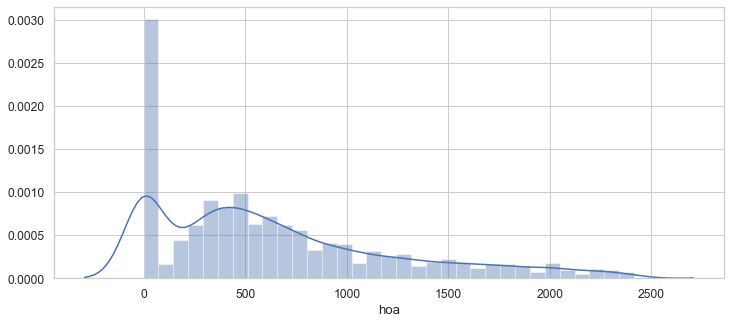

In [32]:
sns.distplot(df_cleaned['hoa']);

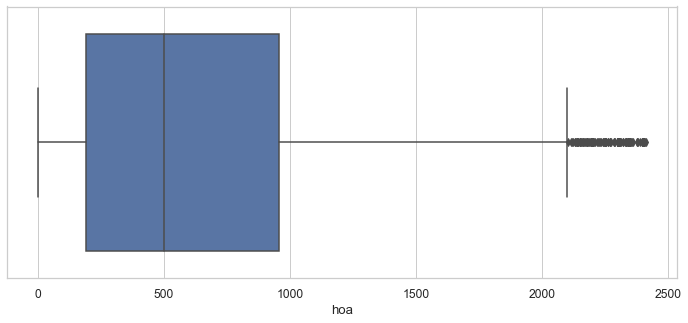

In [33]:
sns.boxplot(df_cleaned['hoa']);

**A maioria dos imóveis não possuem cobrança de taxa de condomínio e 75% dos imóveis possuem a taxa inferior a R$955**.

* **Property Tax (IPTU)**

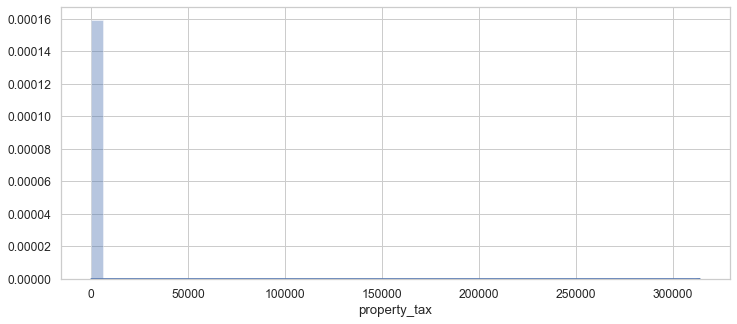

In [34]:
sns.distplot(df_cleaned['property_tax']);

In [35]:
lower_limit_tax, upper_limit_tax = lowerUpperLimit(df_cleaned['property_tax'])
df_cleaned.drop(df_cleaned.query('property_tax < @lower_limit_tax | property_tax > @upper_limit_tax').index, inplace=True)

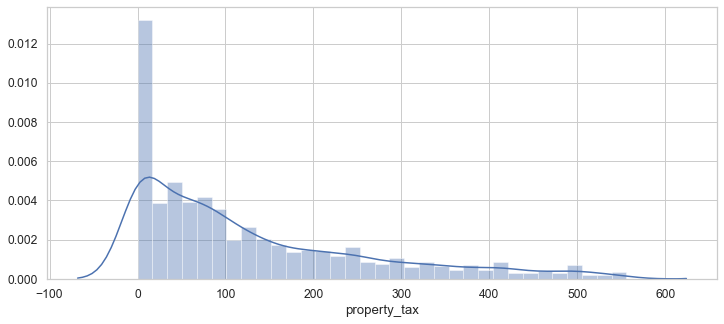

In [36]:
sns.distplot(df_cleaned['property_tax']);

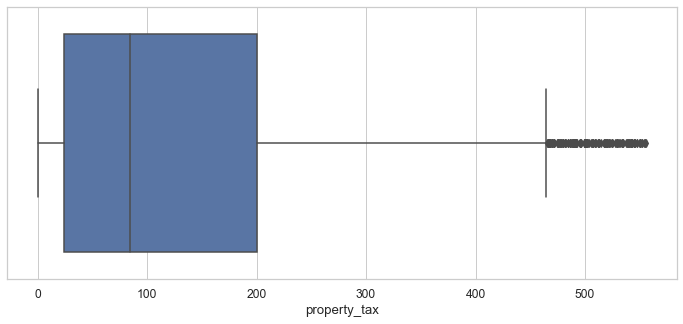

In [37]:
sns.boxplot(df_cleaned['property_tax']);

Podemos observar após a remoção dos outliers que **a maioria dos imóveis não possuem a cobrança de IPTU e que 75% dos imóveis possuem o valor do imposto inferior a R$200.** 

### Análise Exploratória

* **Qual cidade possui o valor médio mais alto para locação?**

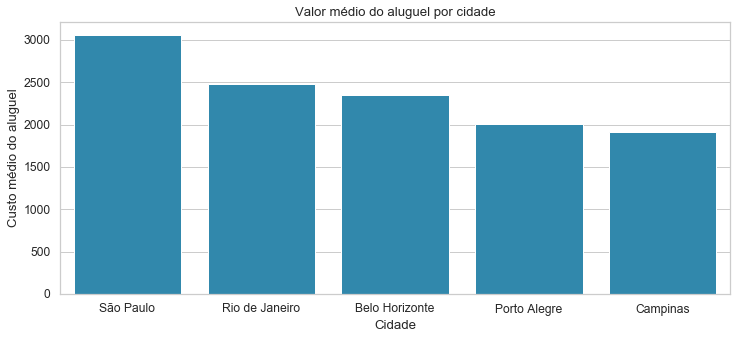

In [38]:
city_rent = df_cleaned.groupby('city')['rent_amount'].mean()
city_rent = pd.DataFrame({'city':city_rent.index, 
                          'average_rent':city_rent.values}).sort_values(by='average_rent', ascending=False)
sns.barplot('city', 'average_rent', data=city_rent, color = '#1d91c0')
plt.xlabel('Cidade')
plt.ylabel('Custo médio do aluguel')
plt.title('Valor médio do aluguel por cidade');

**São Paulo é a cidade que possuí o custo médio mais alto para locação**, em contrapartida, a cidade de **Campinas possuí o menor valor médio de aluguel, sendo inferior a R$2000.**

* **Qual cidade possui os imóveis com o maior tamanho médio?**

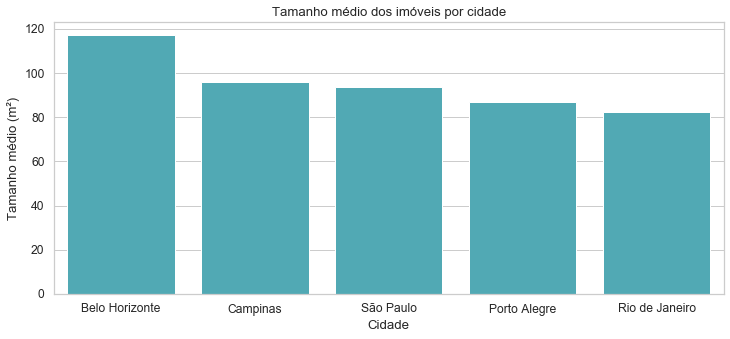

In [39]:
city_area = df_cleaned.groupby('city')['area'].mean()
city_area = pd.DataFrame({'city':city_area.index, 
                          'average_area':city_area.values}).sort_values(by='average_area', ascending=False)
sns.barplot('city', 'average_area', data=city_area, color='#41b6c4')
plt.xlabel('Cidade')
plt.ylabel('Tamanho médio (m²)')
plt.title('Tamanho médio dos imóveis por cidade');

Em média, **os aluguéis em São Paulo são mais caros, porém os imóveis são menores em comparação com Belo Horizonte e Campinas. A cidade do Rio de Janeiro possuí em média os menores imóveis, com tamanho médio inferior a 85 m².**

* **Imóveis localizados em andares mais altos possuem aluguel mais elevado?**

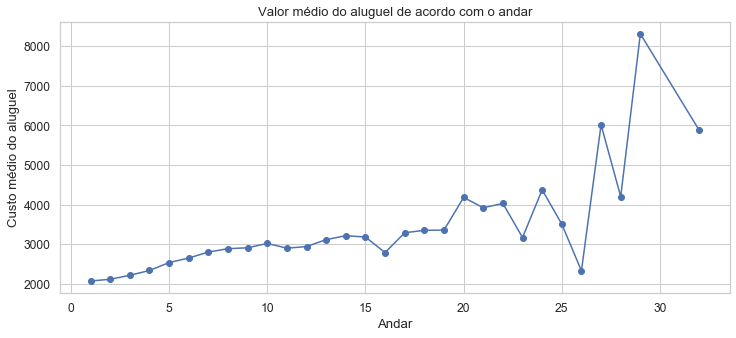

In [40]:
floor_rent = df_cleaned.groupby('floor')['rent_amount'].mean()
floor_rent = pd.DataFrame({'floor':floor_rent.index, 
                          'average_rent':floor_rent.values}).sort_values(by='floor', ascending=False)
plt.plot('floor', 'average_rent', '-bo', data=floor_rent[floor_rent['floor'] > 0])
plt.xlabel('Andar')
plt.ylabel('Custo médio do aluguel')
plt.title('Valor médio do aluguel de acordo com o andar');

Apesar de algumas oscilações, podemos verificar que em média, **o custo médio do aluguel tende a aumentar de acordo com o andar em que o imóvel está localizado.**

* **Imóveis que permitem animais possuem em média maior taxa de condomínio?**

In [41]:
aux_animal = df_cleaned.copy()
aux_animal['animal'].replace(to_replace=1, value='Permite', inplace=True)
aux_animal['animal'].replace(to_replace=0, value='Não permite', inplace=True)

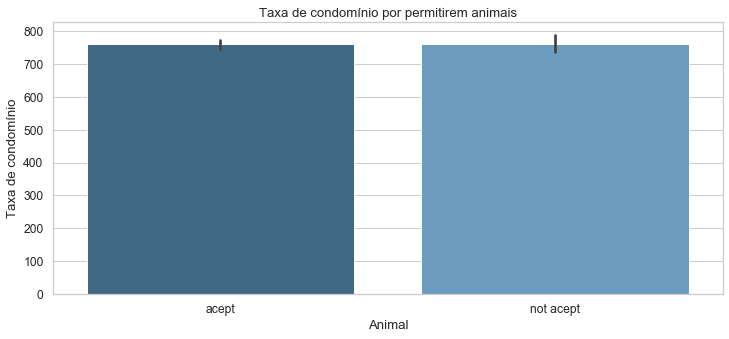

In [42]:
sns.barplot(x='animal', y='hoa', data=aux_animal[aux_animal['hoa'] > 0], palette="Blues_d");
plt.xlabel('Animal')
plt.ylabel('Taxa de condomínio')
plt.title('Taxa de condomínio por permitirem animais');

**O fato do condomínio permitir animal não influência consideravelmente o valor da taxa de administração cobrada.**

* **Imóveis que permitem animais possuem em média aluguel mais caro?**

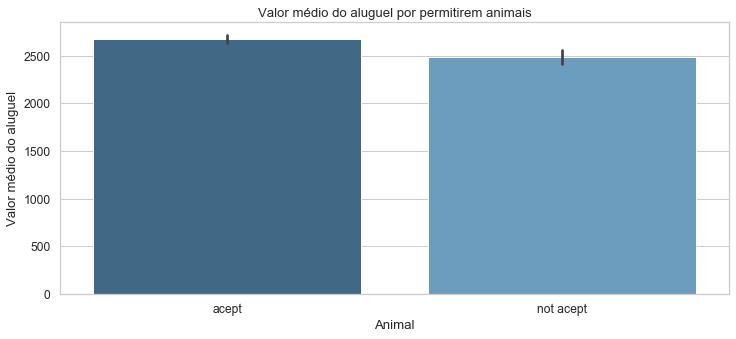

In [43]:
sns.barplot(x='animal', y='rent_amount', data=aux_animal, palette="Blues_d");
plt.xlabel('Animal')
plt.ylabel('Valor médio do aluguel')
plt.title('Valor médio do aluguel por permitirem animais');

Em média, **os imóveis que permitem animais possuem um pequeno acréscimo no valor do aluguel.**

* **Imóveis mobiliados possuem aluguel mais elevado?**

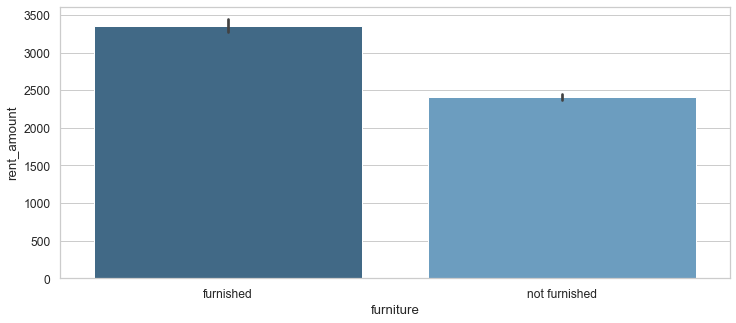

In [44]:
sns.barplot(x='furniture', y='rent_amount', data=df_cleaned, palette="Blues_d");

In [45]:
df_cleaned[df_cleaned['furniture'] == 'furnished']['rent_amount'].mean() - df_cleaned[df_cleaned['furniture'] == 'not furnished']['rent_amount'].mean()

942.5205305356103

**Os imóveis mobiliados custam em média R$942 a mais para serem alugados.**

* **Property Tax (IPTU)**

Identificamos na etapa anterior que a maioria dos imóveis não possuem a cobrança de IPTU. O IPTU é cobrado de acordo com o valor venal do imóvel, além da renda familiar. O valor venal indica qual o valor do imóvel, de acordo com o governo, é calculado com base na quantidade de metros quadrados que a residência possuí e no valor médio do metro quadrado da sua região. 

Vamos analisar os atributos referente a área do imóvel, quantidade quartos, banheiros e valor do aluguel para imóveis que **não possuem a cobrança de IPTU.**

In [46]:
no_tax = df_cleaned[df_cleaned['property_tax'] == 0]

In [47]:
no_tax.groupby('city')[['area', 'rooms', 'bathroom', 'rent_amount']].mean().style.format({"area": "{:20,.2f}",
                                                                                          "rooms": "{:20,.2f}",
                                                                                          "bathroom": "{:20,.2f}",
                                                                                          "rent_amount": "${:20,.0f}"})\
                                                                                 .highlight_max(color='lightgreen')\
                                                                                 .highlight_min(color='#de425b')

,area,rooms,bathroom,rent_amount
city,,,,
Belo Horizonte,77.07,2.08,1.48,"$ 1,681"
Campinas,72.65,1.99,1.53,"$ 1,713"
Porto Alegre,66.56,1.68,1.37,"$ 1,762"
Rio de Janeiro,50.94,1.52,1.18,"$ 1,577"
São Paulo,76.70,1.85,1.51,"$ 2,521"


A cidade do **Rio de Janeiro possuí a menor média para todos atributos, incluindo área, quantidade de banheiros, quartos e consequentemente, o menor aluguel** em comparação com as outras cidades. **São Paulo possuí a maior média de aluguel**, enquanto **Belo Horizonte tem a maior média de área e quantidade de quartos**. Por fim, entre todas as cidades, **Campinas possuí a maior quantidade média de banheiros.**

A seguir, iremos analisar os atributos anteriores para imóveis que **possuem a cobrança de IPTU.**

In [48]:
property_tax = df_cleaned[df_cleaned['property_tax'] > 0]
property_tax.groupby('city')[['area', 'rooms', 'bathroom', 'rent_amount']].mean().style.format({"area": "{:20,.2f}",
                                                                                          "rooms": "{:20,.2f}",
                                                                                          "bathroom": "{:20,.2f}",
                                                                                          "rent_amount": "${:20,.0f}"})\
                                                                                 .highlight_max(color='lightgreen')\
                                                                                 .highlight_min(color='#de425b')

,area,rooms,bathroom,rent_amount
city,,,,
Belo Horizonte,123.87,2.83,2.03,"$ 2,461"
Campinas,99.01,2.26,1.75,"$ 1,938"
Porto Alegre,89.95,2.09,1.64,"$ 2,037"
Rio de Janeiro,87.03,2.15,1.61,"$ 2,616"
São Paulo,98.90,2.20,1.89,"$ 3,214"


**São Paulo mantém a maior média de aluguel** para imóveis com e sem a cobrança de IPTU. Assim como, **Belo Horizonte que mantém a maior média para área e quantidade de quartos em ambas situações, além da maior quantidade de banheiros** para imóveis onde o imposto é cobrado. **Rio de Janeiro possuí a menor média para área e quantidade de quartos** em ambas situações. **Porto Alegre possuí a menor média de quartos** para imóveis com a cobraça de IPTU. E por fim, **Campinas possuí em média o menor aluguel** para imóveis onde o imposto é cobrado.

### Preparação dos Dados  
Nesta etapa, os dados serão preparados e selecionados para o modelo.

In [49]:
df_prepared = df_cleaned.copy()

* **Animal**

O atributo _animal_ se trata de uma variável categórica binária que expressa se um imóvel permite ou não a presença de animais. Iremos transforma-lá em inteiro, onde a presença permitida será representada por 1 (True) e não permitida por 0 (False).

In [50]:
df_prepared['animal'].value_counts()

acept        6372
not acept    1983
Name: animal, dtype: int64

In [51]:
df_prepared['animal'].replace(to_replace='acept', value=1, inplace=True)
df_prepared['animal'].replace(to_replace='not acept', value=0, inplace=True)

* **Furniture**

O atributo *furniture* indica se o imóvel possuí mobília, iremos utilizar a mesma abordagem adotada para o atributo *animal*, onde a presença de mobília será representada por 1 (True) e a ausência por 0 (False).

In [52]:
df_prepared['furniture'].value_counts()

not furnished    6442
furnished        1913
Name: furniture, dtype: int64

In [53]:
df_prepared['furniture'].replace(to_replace='furnished', value=1, inplace=True)
df_prepared['furniture'].replace(to_replace='not furnished', value=0, inplace=True)

* **City**

Iremos realizar a conversão do atributo categórico *city* para numérico utilizando o conceito de [variáveis dummy](https://medium.com/data-hackers/vari%C3%A1veis-dummy-o-que-%C3%A9-quando-usar-e-como-usar-78de66cfcca9). Variáveis dummy são variáveis binárias criadas para representar variáveis categóricas. Como exemplo, temos o atributo *city* com os valores: São Paulo, Belo Horizonte, Campinas, Porto Alegre e Rio de Janeiro. Serão criadas cinco variáveis dummy, representando cada uma das cidades, preenchido com valor 0 (False) e 1 (True).

In [54]:
city_num = pd.get_dummies(df_prepared['city'])
df_prepared = pd.concat([df_prepared, city_num],axis=1)
df_prepared.drop(['city'], axis=1, inplace=True)

* **Correlação**

Como desejamos prever o valor do aluguel dado as características fornecidas pelo usuário, *rent_amount* é nosso atributo alvo. Portanto, vamos verificar qual a correlação dos demais atributos com o valor do aluguel.

In [55]:
df_prepared.corr()['rent_amount'].sort_values(ascending=False)

rent_amount       1.000000
fire_insurance    0.980688
total             0.966503
area              0.564123
bathroom          0.554666
property_tax      0.535302
parking spaces    0.442038
rooms             0.416929
hoa               0.382252
São Paulo         0.239604
furniture         0.225456
floor             0.132281
animal            0.046683
Rio de Janeiro   -0.038434
Belo Horizonte   -0.059654
Campinas         -0.131631
Porto Alegre     -0.141179
Name: rent_amount, dtype: float64

Podemos verificar uma altíssima correlação entre *fire_insurance* e *rent_amount*, tratando de um caso de **multicolinearidade**. Uma regressão não é capaz de fornecer uma solução bem definida na presença de multicolinearidade, portanto iremos remover o atributo *fire_insurance*, assim como os atributos com correlação nula. Além do atributo *total*, considerando que tal valor será fornecido pela aplicação após obtermos o valor previsto para o aluguel e *hoa*, fornecida pelo usuário.

In [56]:
features = df_prepared.columns.drop(['hoa','fire_insurance','total','floor','animal','property_tax','Rio de Janeiro','Belo Horizonte'])
features

Index(['area', 'rooms', 'bathroom', 'parking spaces', 'furniture',
       'rent_amount', 'Campinas', 'Porto Alegre', 'São Paulo'],
      dtype='object')

### Modelo

In [57]:
df = df_prepared[features]

In [58]:
X = df.drop(columns='rent_amount')
y = df['rent_amount']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Primeiramente, iremos implementar um modelo base utilizando [Regressão Linear](https://medium.com/@bruno.dorneles/regress%C3%A3o-linear-conceitos-e-implementa%C3%A7%C3%A3o-com-python-232c19e00f03):

In [67]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train, y_train);

In [68]:
y_pred_lr = model_lr.predict(X_test)
mean_absolute_error(y_pred_lr, y_test)

859.3412970179385

A seguir, implementaremos um modelo de regressão utilizando Random Forest e verificar se obtemos um menor erro médio absoluto:

In [69]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train);

In [70]:
y_pred_rf = model_rf.predict(X_test)
mean_absolute_error(y_pred_rf, y_test)

870.010464759244

Obtemos melhor resultado através do modelo utilizando Regressão Linear. Poderíamos realizar o ajuste dos parâmetros no modelo implementado com Random Forest em busca de um melhor resultado, mas não é foco deste projeto. Por fim, iremos salvar o modelo final para ser utilizado na aplicação:

In [64]:
joblib.dump(model_lr, "model.pkl")

['model.pkl']

### Aplicação

A aplicação desenvolvida cumpre com o objetivo final do projeto, reduzir custos internos através da automatização do processo de oferta de imóveis. A aplicação permite que o usuário anuncie o seu imóvel, inserindo seus atributos e taxas relacionadas. Por fim, é realizado a previsão do valor do aluguel do imóvel baseado nas informações fornecidas pelo usuário.  
**[Acesse e anuncie seu imóvel!](https://app-real-state.herokuapp.com/)**.  

<img src="tutorial.gif" width="1000" height="1000"/>

### Referências
* [Codenation](codenation.dev)
* [Estatística Prática Para Cientistas de Dados](https://www.amazon.com.br/Estat%C3%ADstica-Pr%C3%A1tica-Para-Cientistas-Dados/dp/855080603X/ref=asc_df_855080603X/?tag=googleshopp00-20&linkCode=df0&hvadid=379765802390&hvpos=&hvnetw=g&hvrand=18089891648120664353&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1001599&hvtargid=pla-812161948748&psc=1)
* [Mãos à Obra: Aprendizado de Máquina com Scikit-Learn & TensorFlow](https://www.amazon.com.br/M%C3%A3os-Obra-Aprendizado-Scikit-Learn-TensorFlow/dp/8550803812)
* [Towards Data Science - Understanding Boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)
* [Towards Data Science - Style Pandas Dataframe Like a Master](https://towardsdatascience.com/style-pandas-dataframe-like-a-master-6b02bf6468b0)
* [Data Hackers - Variáveis Dummy](https://medium.com/data-hackers/vari%C3%A1veis-dummy-o-que-%C3%A9-quando-usar-e-como-usar-78de66cfcca9)
* [Regressão Linear](https://medium.com/@bruno.dorneles/regress%C3%A3o-linear-conceitos-e-implementa%C3%A7%C3%A3o-com-python-232c19e00f03)

Deixa sua crítica ou sugestão e me ajude a evoluir😉
* [LinkedIn](https://www.linkedin.com/in/bruno-dorneles/)
* [GitHub](https://github.com/BrunoDorneles)
* [Medium](https://medium.com/@bruno.dorneles)